# TIPE 2023-2024 "Jeux et sports" 
### MORAIN Arthur MP2 Montaigne

## <ins>Optimisation de l'arrêt au stand en Formule 1</ins> 

### **<ins>VI- Analyse de données v2 :</ins>**   

#### **<ins>a- ouverture :</ins>**  

In [1]:
import os
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [2]:
df = pd.read_csv('/Users/morainarthur/Home/Datascience/redbull-pit-strategy/data/CSV/lapweatherf1.csv')

/var/folders/vk/f22z063n5rl20ps172zv7gxm0000gn/T/ipykernel_42001/1540634805.py:1: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/morainarthur/Home/Datascience/redbull-pit-strategy/data/CSV/lapweatherf1.csv')


In [3]:
df.head()

,EventName,eventYear,Team,session,Driver,level_5,Time,DriverNumber,LapTime,LapNumber,...,Sector2SessionTime,Sector3SessionTime,IsAccurate,WindSpeed,AirTemp,Humidity,Pressure,TrackTemp,Rainfall,WindDirection
0,70th Anniversary Grand Prix,2020,Alfa Romeo Racing,FP1,KUB,0,0 days 00:18:07.531000,88,NaN,1.0,...,0 days 00:17:36.888000,0 days 00:18:07.598000,False,2.7,25.3,49.6,1001.5,34.6,False,231.0
1,70th Anniversary Grand Prix,2020,Alfa Romeo Racing,FP1,KUB,1,0 days 00:35:28.649000,88,NaN,2.0,...,0 days 00:34:57.975000,0 days 00:35:28.775000,False,3.4,26.4,43.6,1001.5,37.2,False,222.0
2,70th Anniversary Grand Prix,2020,Alfa Romeo Racing,FP1,KUB,2,0 days 00:37:00.685000,88,0 days 00:01:32.036000,3.0,...,0 days 00:36:35.547000,0 days 00:37:00.685000,True,2.1,26.0,44.8,1001.5,36.7,False,212.0
3,70th Anniversary Grand Prix,2020,Alfa Romeo Racing,FP1,KUB,3,0 days 00:39:11.032000,88,0 days 00:02:10.347000,4.0,...,0 days 00:38:34.621000,0 days 00:39:11.032000,True,2.5,26.2,43.9,1001.5,37.6,False,189.0
4,70th Anniversary Grand Prix,2020,Alfa Romeo Racing,FP1,KUB,4,0 days 00:40:41.364000,88,0 days 00:01:30.332000,5.0,...,0 days 00:40:16.516000,0 days 00:40:41.364000,True,1.2,26.3,43.3,1001.5,37.9,False,219.0


#### **<ins>b- une vérification :</ins>**  

In [4]:
df.isnull().sum()

EventName                  0
eventYear                  0
Team                       0
session                    0
Driver                     0
level_5                    0
Time                       0
DriverNumber               0
LapTime                36666
LapNumber                  0
Stint                   1018
PitOutTime            247895
RoundNumber                0
PitInTime             247978
SpeedST                18502
IsPersonalBest           158
Compound                1441
TyreLife                1441
FreshTyre                  0
LapStartTime               0
TrackStatus              158
LapStartDate            3209
country                    0
EventDate                  0
lapTimeSec             36666
Sector1Time            26630
Sector2Time             1899
Sector3Time             7136
Sector1SessionTime     27046
Sector2SessionTime      1899
Sector3SessionTime      7136
IsAccurate                 0
WindSpeed                287
AirTemp                  287
Humidity      

In [5]:
df.columns

Index(['EventName', 'eventYear', 'Team', 'session', 'Driver', 'level_5',
       'Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'RoundNumber', 'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound',
       'TyreLife', 'FreshTyre', 'LapStartTime', 'TrackStatus', 'LapStartDate',
       'country', 'EventDate', 'lapTimeSec', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'IsAccurate', 'WindSpeed', 'AirTemp', 'Humidity',
       'Pressure', 'TrackTemp', 'Rainfall', 'WindDirection'],
      dtype='object')

In [6]:
df[df['session']=='Race'].isnull().sum()

EventName                  0
eventYear                  0
Team                       0
session                    0
Driver                     0
level_5                    0
Time                       0
DriverNumber               0
LapTime                 2548
LapNumber                  0
Stint                    343
PitOutTime            108234
RoundNumber                0
PitInTime             108101
SpeedST                 8578
IsPersonalBest           136
Compound                 343
TyreLife                 343
FreshTyre                  0
LapStartTime               0
TrackStatus              136
LapStartDate            1128
country                    0
EventDate                  0
lapTimeSec              2548
Sector1Time             2427
Sector2Time              255
Sector3Time              323
Sector1SessionTime      2702
Sector2SessionTime       255
Sector3SessionTime       323
IsAccurate                 0
WindSpeed                  0
AirTemp                    0
Humidity      

On ne perd donc pas tant de données que ça

cela peut s'expliquer par l'annulation de tour ou la disqualification, ou l'abandon

#### <ins> c- les graphiques :</ins>

In [7]:
"""
Créer une colonne pour identifier les tours avec un grand delta-temps entre les tours consécutifs
Dans des conditions normales de course, délai entre deux tours consécutifs.
"""

df['large_delta_time'] = np.nan
df['delta_lapTime'] = np.nan


## create a column for delta_lapTime'
df['delta_lapTime'] = df.groupby(['EventName','eventYear','Driver','session','Stint'])['lapTimeSec'].diff()


## label those who are biger or smaller than +-2
df['large_delta_time']= (df['delta_lapTime']<2) & (df['delta_lapTime']>-2)
print(sum(df['large_delta_time']))

120305


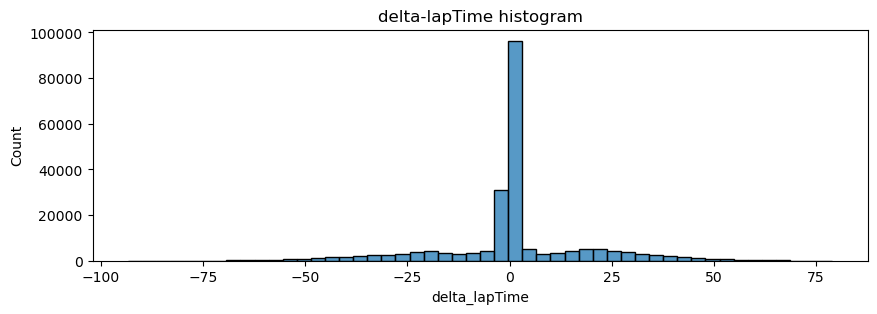

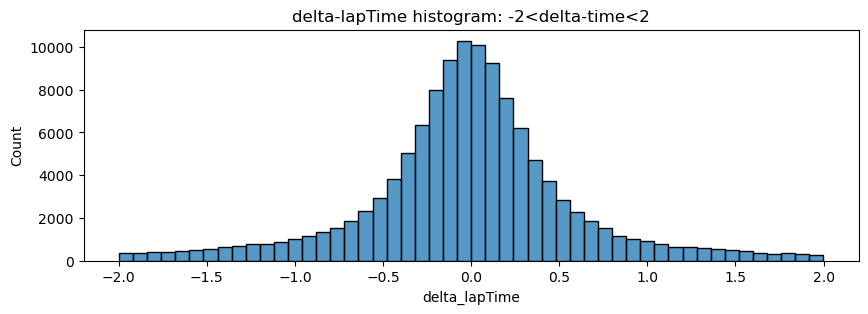

In [8]:
## delta-lapTime histogram without filtering
fig = plt.figure(figsize=(10,3))
sns.histplot(df[df['delta_lapTime'].notnull()],x = 'delta_lapTime', bins=50)
plt.title('delta-lapTime histogram')
plt.show()

fig = plt.figure(figsize=(10,3))
## detal-lapTime histogram with filtering
sns.histplot(df[df['large_delta_time']],x = 'delta_lapTime', bins=50)
plt.title('delta-lapTime histogram: -2<delta-time<2')
plt.show()

# Note: delta-laptime is the delta between two consecutive laps

On remarque directement que pour un tour de f1 l'intervalle de temps (différence entre deux tours) est assez faible mais à cette échelle cela devient rapidement grand

In [11]:
df_lapWeather = df
sub_lap = df_lapWeather[(df_lapWeather['EventName']=='Austrian Grand Prix') &
        (df_lapWeather['Team']=='Mercedes') &
        (df_lapWeather['session']=='Race') &
       (df_lapWeather['eventYear']==2019) &
        (df_lapWeather['Driver']=='HAM')].sort_values('Time').reset_index(drop=True) 

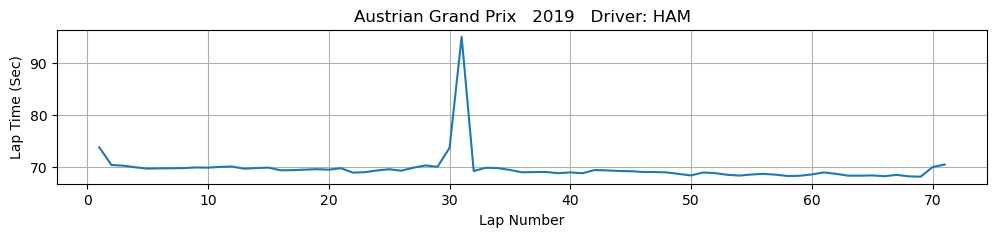

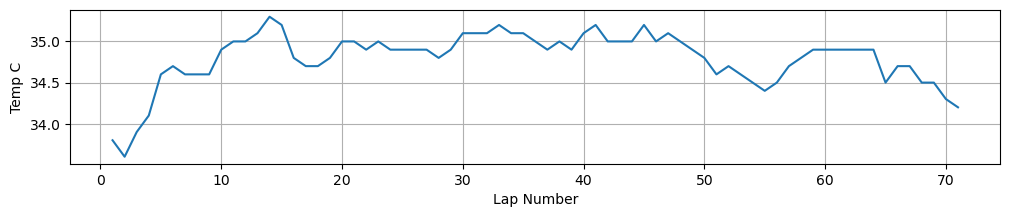

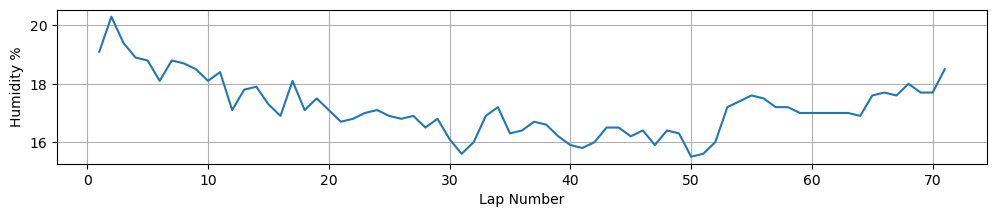

In [13]:
fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['lapTimeSec'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (Sec)')
plt.title(sub_lap['EventName'][0]+ '   ' +
          str(sub_lap['eventYear'].values[0])+ '   Driver: ' +
          sub_lap['Driver'][0])



# Second visualization: plot air temperature vs. lap number (varies with the weather)
fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['AirTemp'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Temp C')




# Third visualization: plot humidity % vs. lap number (varies with the weather)
fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['Humidity'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Humidity %')

plt.show()

In [18]:
def plot_lap_times(df_sub, event,driver, session):   

    
    a = 0
    b = len(df_sub)
    
    Compound = df_sub['Compound'][a:b]
    
    print('Session: ',session, '\n','driver_name', np.unique(df_sub['Driver']),'\n', 
          'Compond: ', np.unique(Compound[Compound.notnull()]))
    
    lapNumber = np.arange(a,b)
    lapTime = df_sub['lapTimeSec']
    plot_laptime = lapTime[a:b]
    
    ## charts
    fig = plt.figure(figsize=(15,3))
    plt.plot(lapNumber, plot_laptime, color='green')
    plt.plot(lapNumber[df_sub['large_delta_time']],  
             df_sub[df_sub['large_delta_time']]['lapTimeSec'] ,'.',color='black')  
    
    ### plot labels, title, etc
    top = 105
    bot = np.nanmin( plot_laptime) #plot_laptime
    print('bot: ',bot)
    if (~np.isnan(bot) )&(session!='Qual') :
        plt.ylim(bot,top)
        d = (top-bot)/10

        for ii in range(a,b,5):
            plt.text(ii-1,top-4*d , df_sub['Compound'][ii], fontsize = 10)
            plt.text(ii-1,top-2*d,df_sub['Stint'][ii], fontsize = 10)
        plt.xticks(lapNumber, df_sub['LapNumber'],rotation=45)
        plt.xlabel('LapNumber', fontsize = 16)
        plt.title('event: '+event+',    '+'driver: '+driver, fontsize = 14)
        plt.ylabel(' time', fontsize = 14)
        plt.legend(['stintLapTimeLine','stintLapTime','stintLapTimeLineCorred',
                    'regLinePoints','stintLapTimeCorred'],fontsize = 11)

        plt.grid(visible=True)
        plt.show()
    
    return

Session:  Race 
 driver_name ['HAM'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  86.057


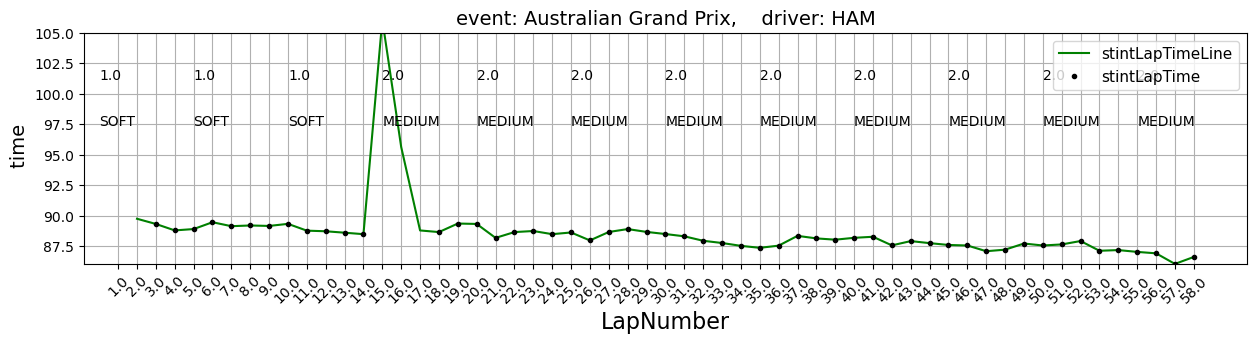

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['LEC'] 
 Compond:  ['HARD' 'SOFT']
bot:  86.926


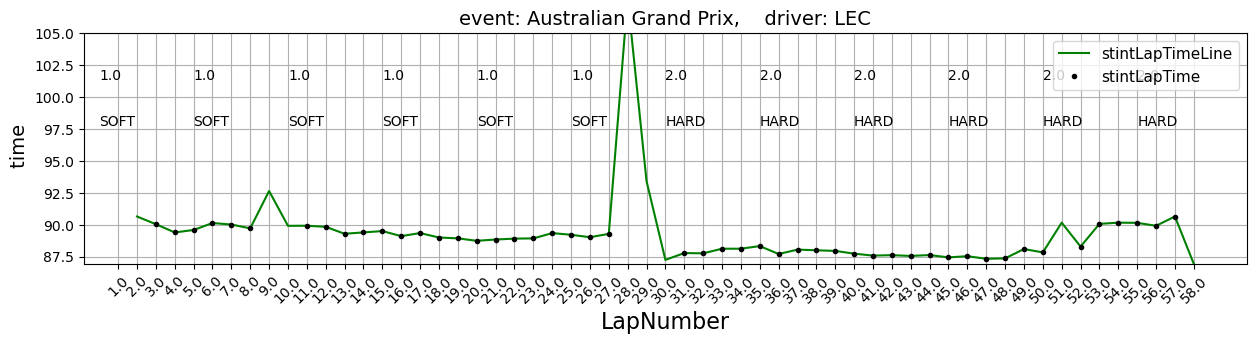

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['VET'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  87.954


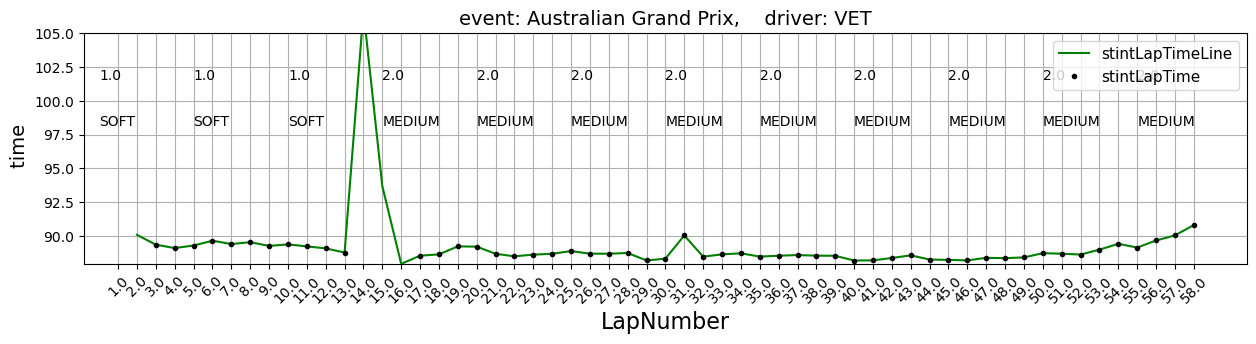

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['HAM'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  93.528


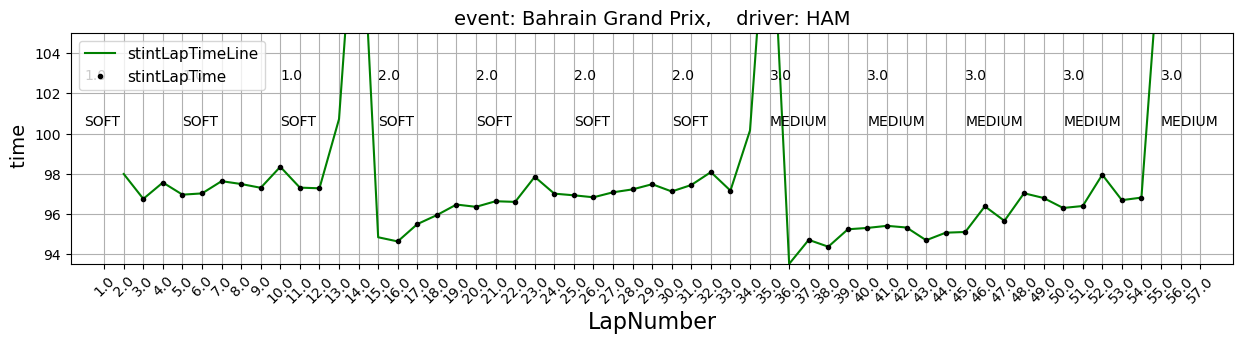

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['LEC'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  93.411


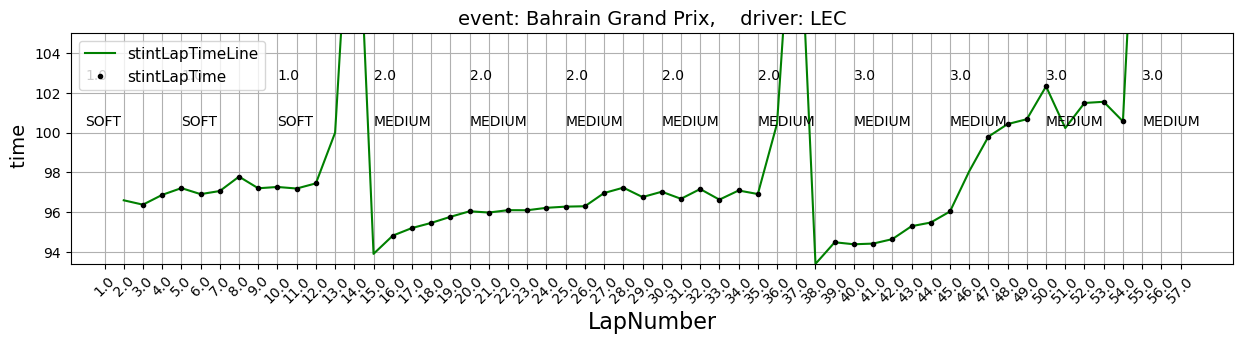

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['VET'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  94.895


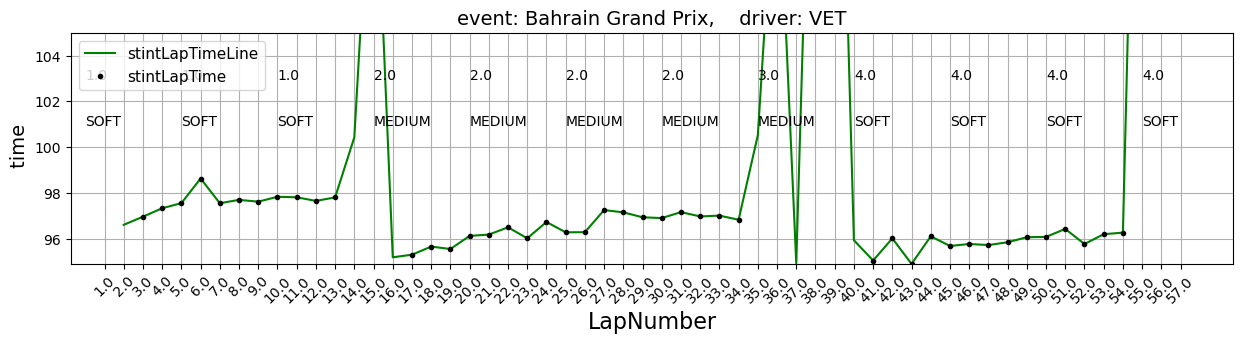

****************************************************************************************************************************************************** 



In [19]:
events = np.unique(df['EventName'])
# Print lap times for 3 drivers in 2 events
for evnt in ['Australian Grand Prix', 'Bahrain Grand Prix' ]:
    drivers = np.unique(df['Driver'][df['EventName']==evnt])
    for drvs in ['HAM','LEC','VET']:
        
        sub_df = df[(df['EventName']==evnt) & (df['Driver']==drvs) &  
                    (df['session']=='Race') &(df['eventYear']==2019)].sort_values(by = ['LapNumber']).reset_index(drop=True)
        if len(sub_df):
            plot_lap_times(sub_df,evnt,drvs, 'Race')
            
        print('*' * 150,"\n")

In [21]:
df.columns

Index(['EventName', 'eventYear', 'Team', 'session', 'Driver', 'level_5',
       'Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'RoundNumber', 'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound',
       'TyreLife', 'FreshTyre', 'LapStartTime', 'TrackStatus', 'LapStartDate',
       'country', 'EventDate', 'lapTimeSec', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'IsAccurate', 'WindSpeed', 'AirTemp', 'Humidity',
       'Pressure', 'TrackTemp', 'Rainfall', 'WindDirection',
       'large_delta_time', 'delta_lapTime'],
      dtype='object')

#### <ins> d- Etude du data de base : </ins>

-> Permettra de vérifier les coordonances avec nos résultats

In [30]:
data_path = '/Users/morainarthur/Home/Datascience/redbull-pit-strategy/data/CSV/'
df = pd.read_csv(data_path+'final_data.csv')

## on retire les relais de moins de 5tours (cas particulier)
## SintNumber==1
df = df[(df['StintLen']>5) & (df['Stint']==1)] #& (df['Stint']==1)


# Remove unreliable stint lengths
## bucketize `target variable` and assign a label to each bucket
bins = np.array([5,10,15,20,25,30,35])
labels = np.arange(len(bins)-1)

df['classLabels'] = pd.cut(df.StintLen, 
                           bins=bins,
                           labels=labels)



print('-'*80)
print('Size of Data: ', df.shape,'\n', '-'*80,'\n')

df.describe()

--------------------------------------------------------------------------------
Size of Data:  (1373, 29) 
 -------------------------------------------------------------------------------- 



,Unnamed: 0,RoundNumber,eventYear,Stint,bestPreRaceTime,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,...,lapNumberAtBeginingOfStint,StintLen,CircuitLength,designedLaps,fuel_slope,fuel_bias,deg_slope,deg_bias,lag_slope_mean,lag_bias_mean
count,1373.000000,1373.000000,1373.000000,1373.0,1365.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,...,1373.000000,1373.000000,1373.000000,1373.000000,1137.000000,1137.000000,1241.000000,1241.000000,532.000000,532.000000
mean,2273.745084,10.367079,2019.660597,1.0,83.898933,23.614400,36.595104,50.758510,0.043544,10.146395,...,1.204661,21.149308,5.105441,61.090313,-0.095510,92.592749,-0.052847,91.586514,-0.033368,91.015843
std,1375.456984,6.046165,1.314263,0.0,12.192563,5.173816,9.717652,15.795047,0.178238,5.729417,...,0.431529,9.878061,0.762718,8.689946,0.244012,12.710955,0.288313,12.810528,0.188845,12.021530
min,2.000000,1.000000,2018.000000,1.0,53.377000,9.257143,15.100000,5.952381,0.000000,0.000000,...,1.000000,6.000000,3.337000,44.000000,-2.228067,67.187503,-4.171178,58.139028,-2.263061,58.208277
25%,1077.000000,5.000000,2019.000000,1.0,75.593000,20.657143,30.100000,38.960870,0.000000,5.000000,...,1.000000,13.000000,4.381000,53.000000,-0.101807,82.404967,-0.079245,81.968137,-0.069177,82.845709
50%,2236.000000,9.000000,2019.000000,1.0,82.540000,23.339130,36.477778,52.969231,0.000000,10.000000,...,1.000000,20.000000,5.303000,58.000000,-0.067897,93.002578,-0.032852,91.608029,-0.026810,90.827078
75%,3500.000000,16.000000,2021.000000,1.0,92.750000,27.173684,43.985000,60.220000,0.000000,15.000000,...,1.000000,27.000000,5.793000,70.000000,-0.044889,102.429229,0.016138,101.308115,0.013461,100.380985
max,4609.000000,22.000000,2022.000000,1.0,136.522000,36.933333,56.500000,93.861905,1.000000,20.000000,...,3.000000,64.000000,7.004000,87.000000,1.353067,135.657542,0.892500,143.581418,0.606236,132.102434


*** x  **************************************************************************************************** 



,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,Position,StintLen
meanAirTemp,1.000000,0.663451,-0.452464,-0.174901,0.002501,-0.000091,0.011903
meanTrackTemp,0.663451,1.000000,-0.556186,-0.171038,-0.012052,0.000535,0.022260
meanHumid,-0.452464,-0.556186,1.000000,0.101989,0.015289,0.004451,0.063148
Rainfall,-0.174901,-0.171038,0.101989,1.000000,0.018719,0.002400,0.020522
GridPosition,0.002501,-0.012052,0.015289,0.018719,1.000000,0.631952,0.112158
Position,-0.000091,0.000535,0.004451,0.002400,0.631952,1.000000,-0.051509
StintLen,0.011903,0.022260,0.063148,0.020522,0.112158,-0.051509,1.000000


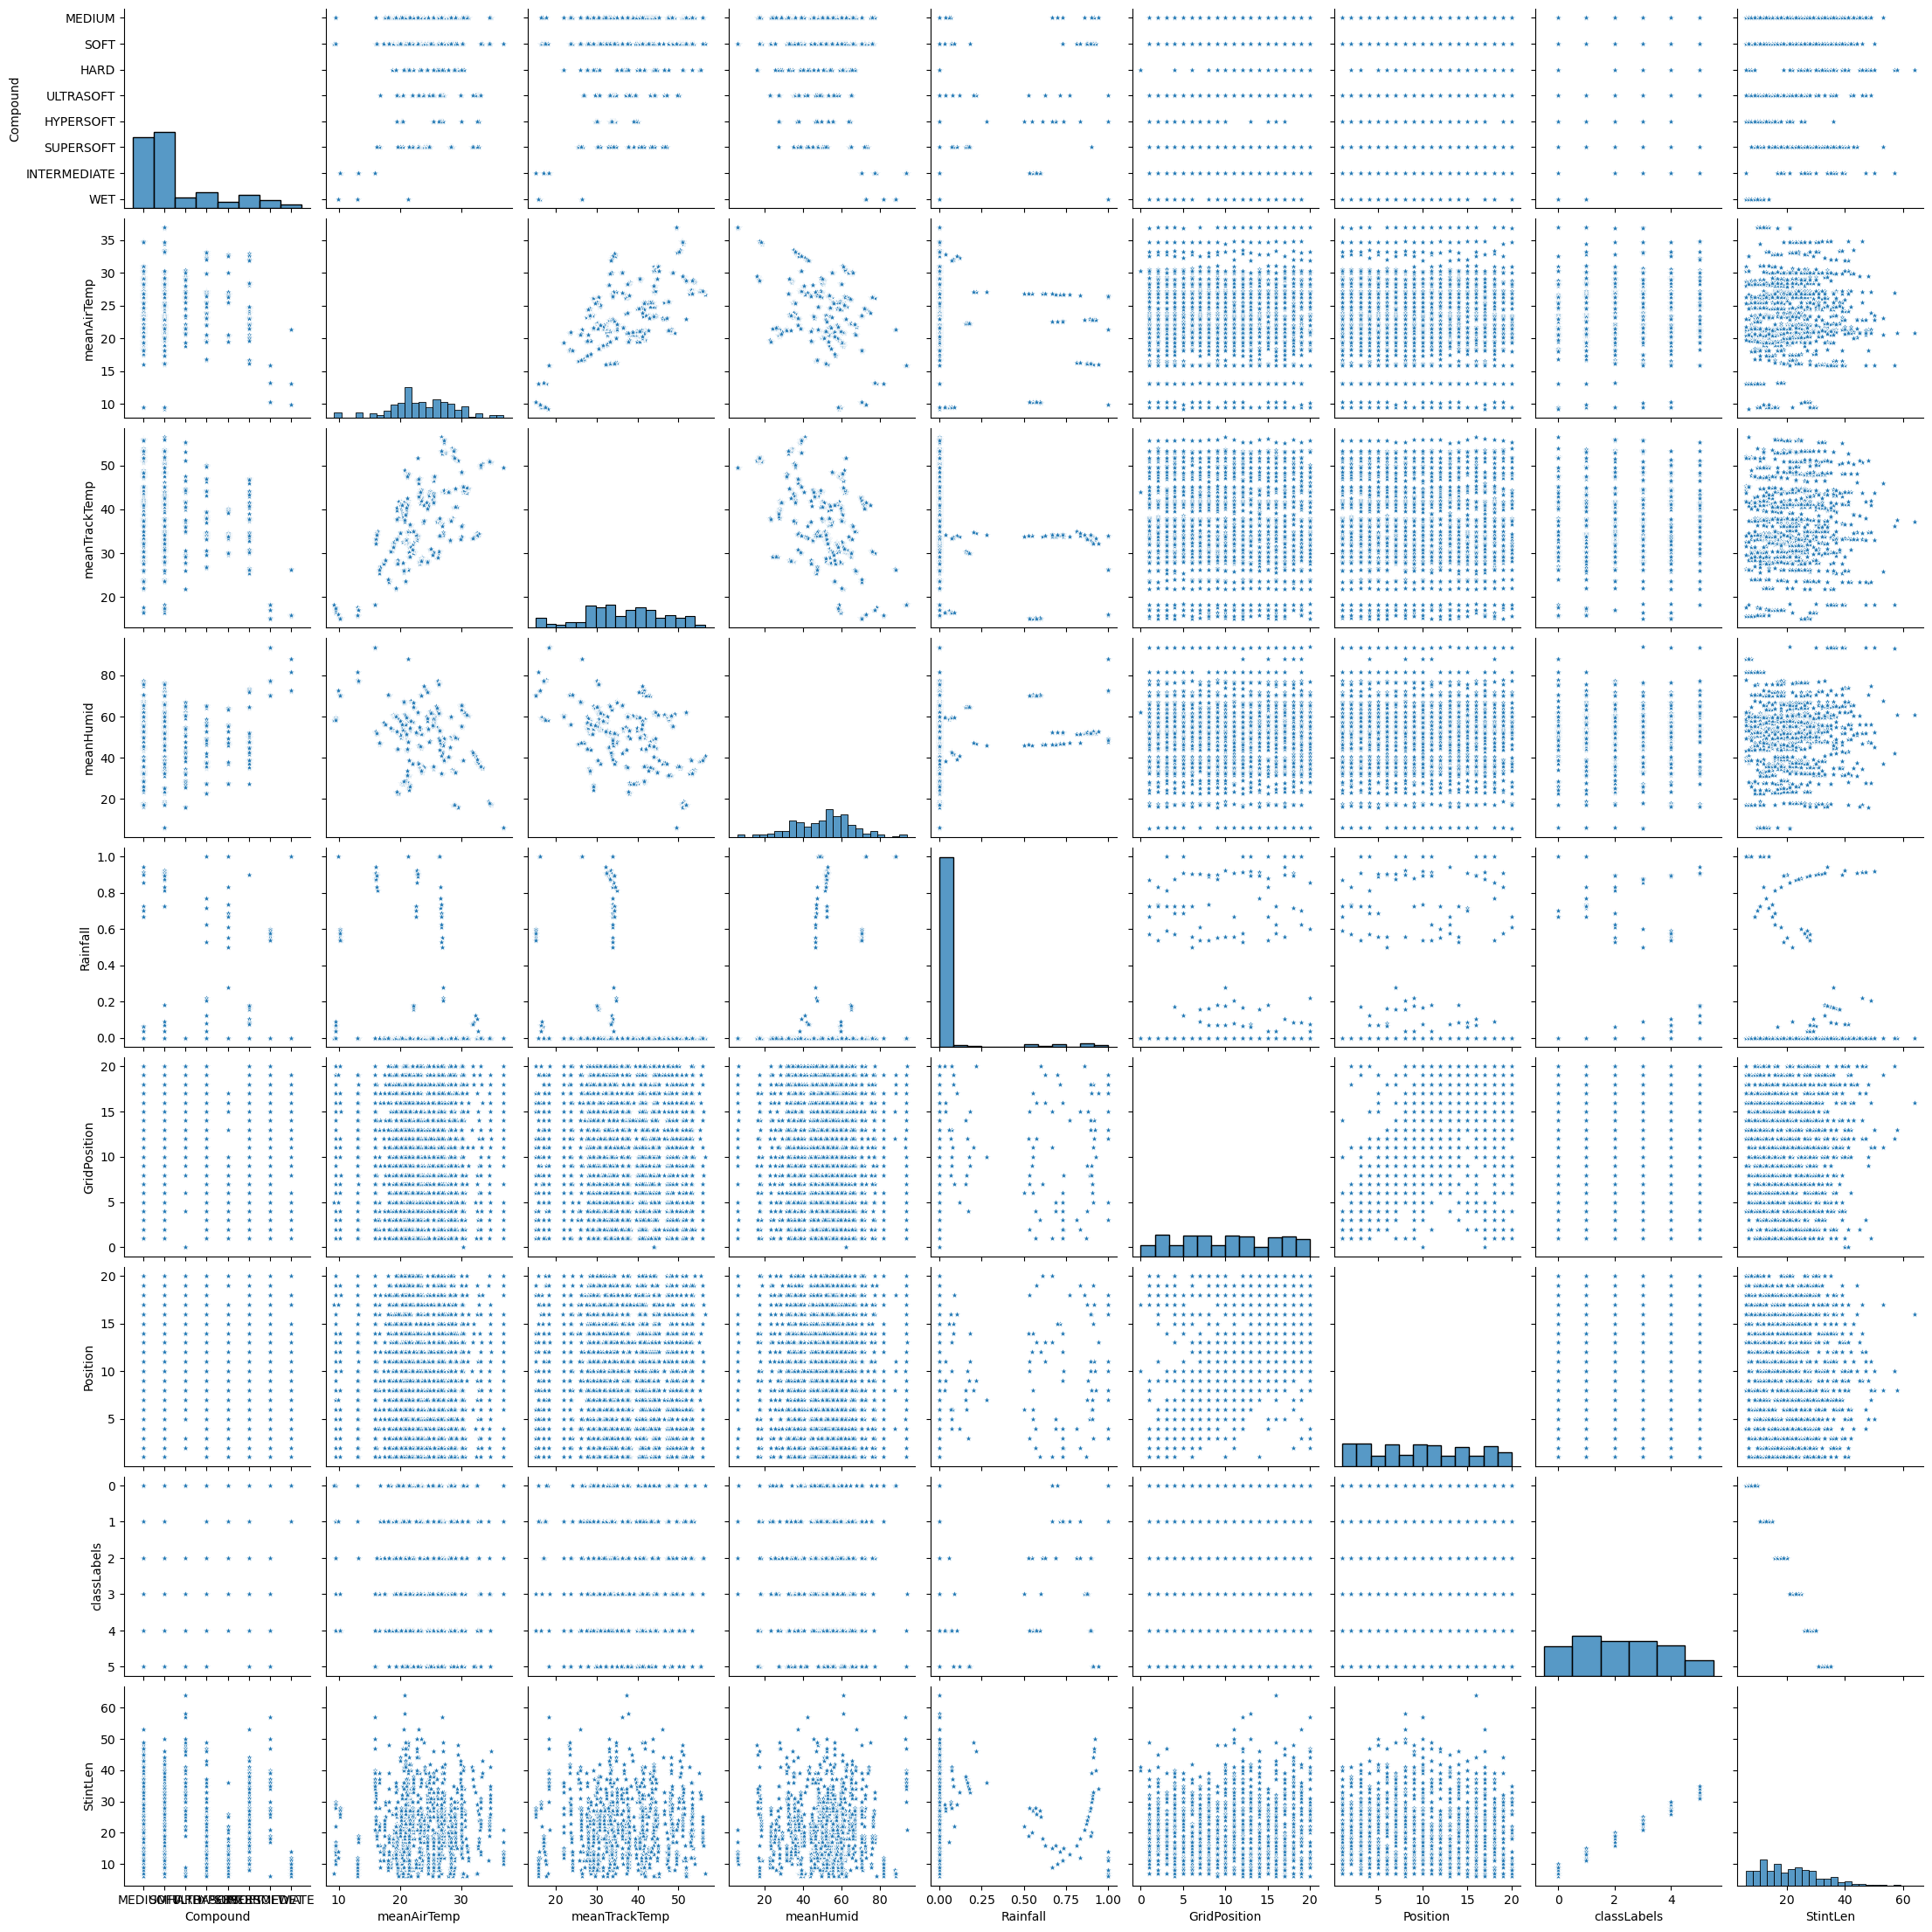

In [31]:
columns = ['Compound', 'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 
           'GridPosition', 'Position','classLabels',
           'StintLen']

x = df[columns].reset_index(drop=True)


print('*** x  '+'*' * 100,"\n")
display(x[columns].corr())
sns.pairplot(x, vars=columns, palette = "Set2", markers='*')
plt.show()

In [35]:
df['Compound'].count

<bound method Series.count of 2       MEDIUM
3       MEDIUM
7         SOFT
8         SOFT
10        HARD
         ...  
4599      SOFT
4601      HARD
4603      SOFT
4608    MEDIUM
4609    MEDIUM
Name: Compound, Length: 1373, dtype: object>

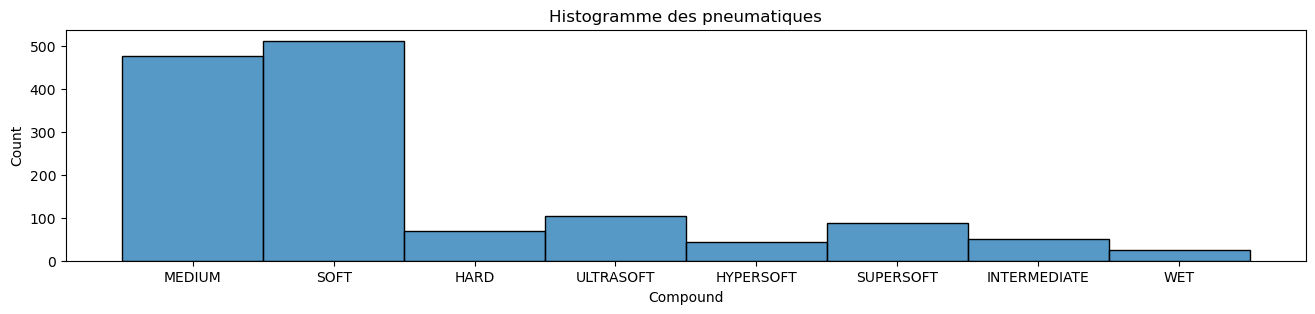

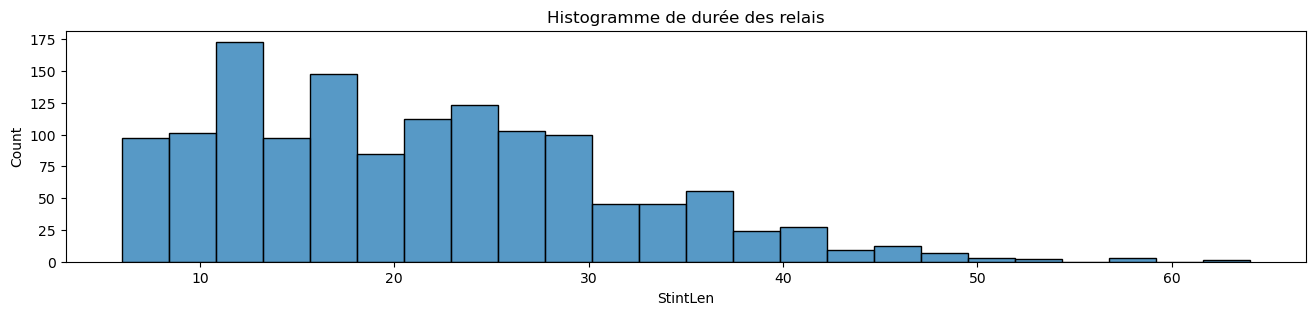

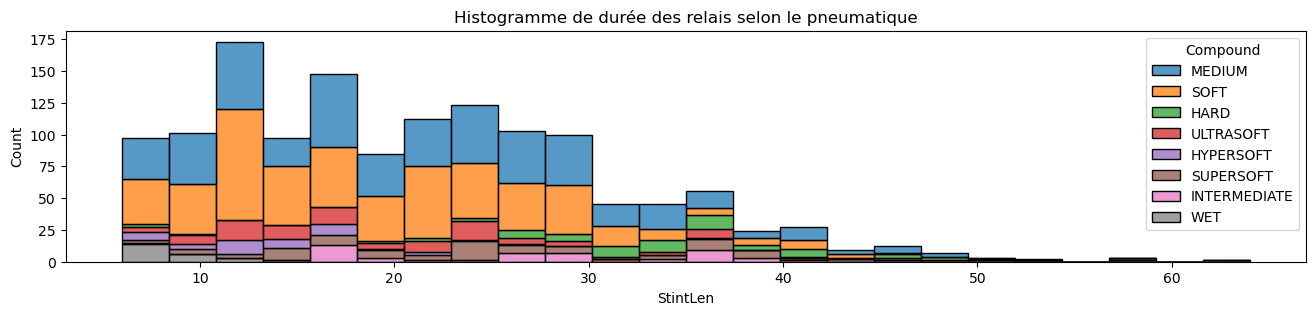

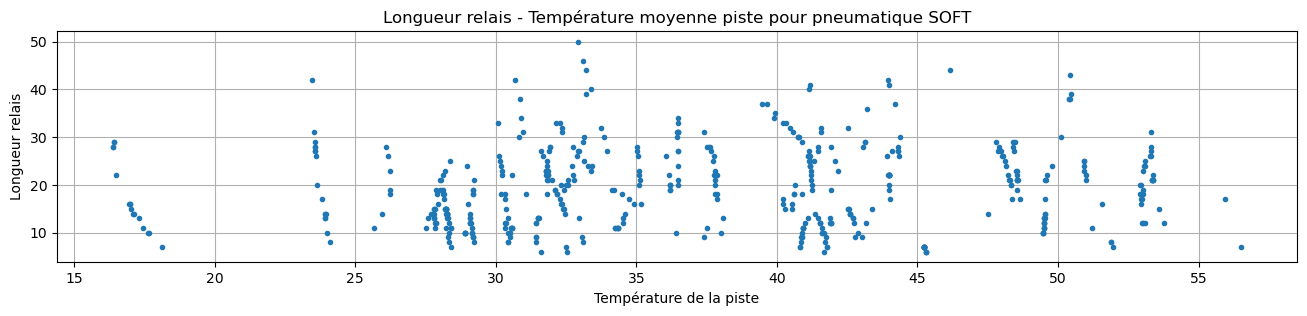

In [36]:
plt.figure(figsize=(16,3))
sns.histplot(data=df, x="Compound", multiple="stack")
plt.title('Histogramme des pneumatiques')


plt.figure(figsize=(16,3))
sns.histplot(data=df, x="StintLen")
plt.title('Histogramme de durée des relais')


plt.figure(figsize=(16,3))
sns.histplot(data=df, x="StintLen", hue="Compound", multiple="stack")
plt.title('Histogramme de durée des relais selon le pneumatique')


plt.figure(figsize=(16,3))
plt.plot(df['meanTrackTemp'][df['Compound']=='SOFT'],df['StintLen'][df['Compound']=='SOFT'],'.')
plt.grid()
plt.title('Longueur relais - Température moyenne piste pour pneumatique SOFT')
plt.xlabel('Température de la piste')
plt.ylabel('Longueur relais')


plt.show()

En exigeant une longueur de relais plus faible

Text(0.5, 1.0, 'Histogramme de durée des relais')

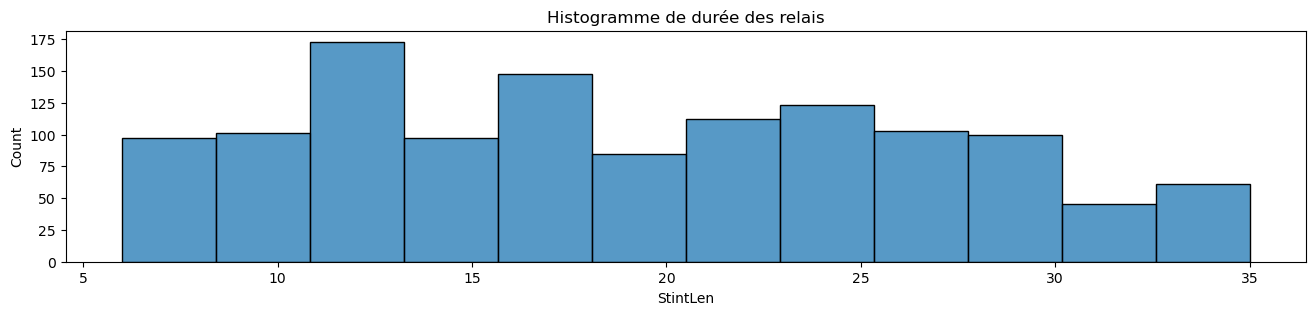

In [37]:
df2 = df[df['StintLen']<=35]
plt.figure(figsize=(16,3))
sns.histplot(data=df2, x="StintLen")
plt.title('Histogramme de durée des relais')

Text(0.5, 1.0, 'Histogramme de durée des relais selon le pneumatique')

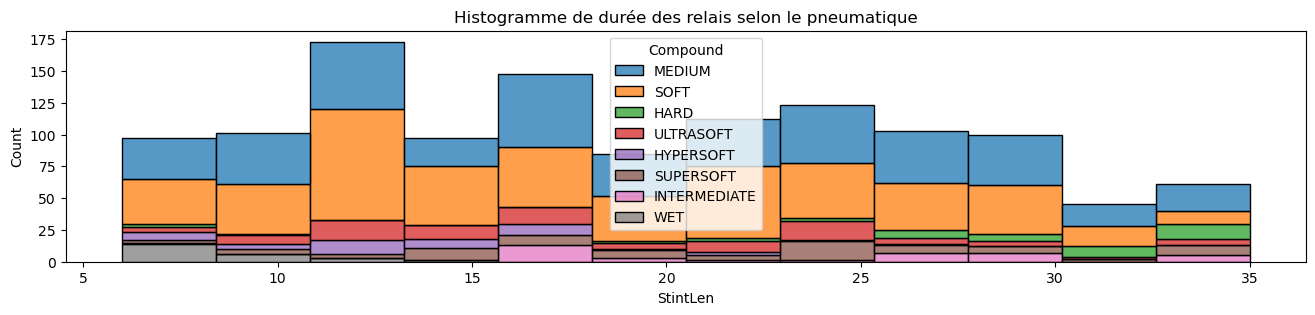

In [38]:
plt.figure(figsize=(16,3))
sns.histplot(data=df2, x="StintLen", hue="Compound", multiple="stack")
plt.title('Histogramme de durée des relais selon le pneumatique')

Text(0, 0.5, 'Longueur relais')

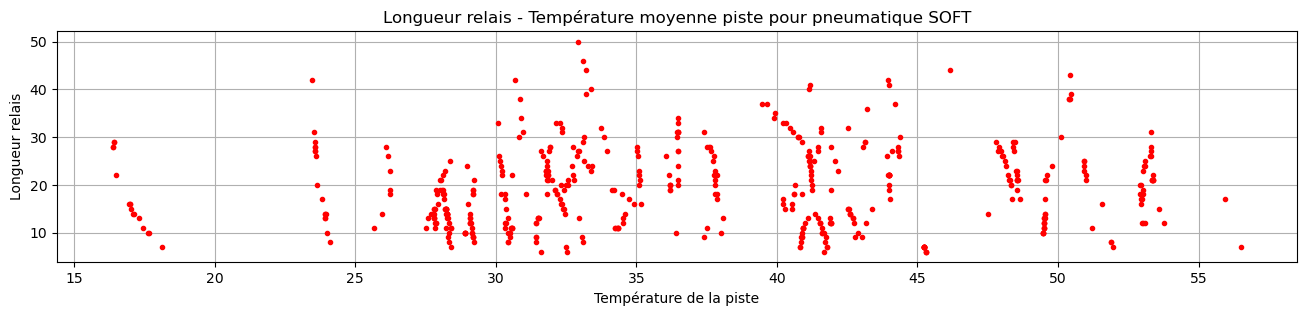

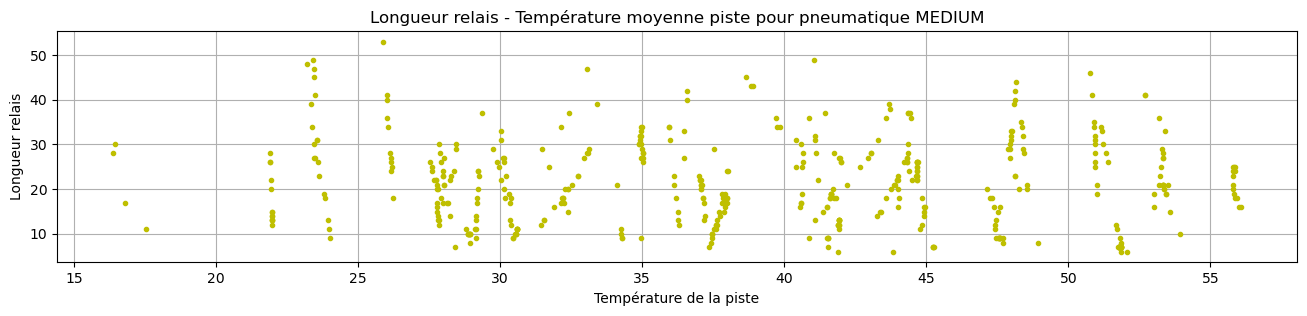

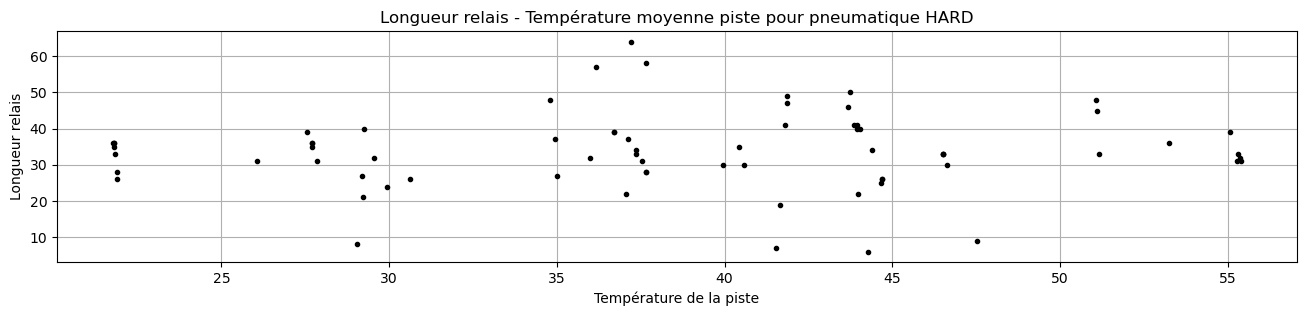

In [43]:
plt.figure(figsize=(16,3))
plt.plot(df['meanTrackTemp'][df['Compound']=='SOFT'],df['StintLen'][df['Compound']=='SOFT'],'.',color = 'r')
plt.grid()
plt.title('Longueur relais - Température moyenne piste pour pneumatique SOFT')
plt.xlabel('Température de la piste')
plt.ylabel('Longueur relais')

plt.figure(figsize=(16,3))
plt.plot(df['meanTrackTemp'][df['Compound']=='MEDIUM'],df['StintLen'][df['Compound']=='MEDIUM'],'.',color = 'y')
plt.grid()
plt.title('Longueur relais - Température moyenne piste pour pneumatique MEDIUM')
plt.xlabel('Température de la piste')
plt.ylabel('Longueur relais')

plt.figure(figsize=(16,3))
plt.plot(df['meanTrackTemp'][df['Compound']=='HARD'],df['StintLen'][df['Compound']=='HARD'],'.',color = 'k')
plt.grid()
plt.title('Longueur relais - Température moyenne piste pour pneumatique HARD')
plt.xlabel('Température de la piste')
plt.ylabel('Longueur relais')